# Problem Set 5, due June 1 at 11:59 pm.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [52]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews.fresh.dropna()
reviews = reviews[reviews.quote.str.len() > 0]

reviews.quote = reviews.quote.str.replace('[^\w\s]', '')
reviews.quote = reviews.quote.str.replace('[0-9]', '')

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [53]:
# enter your code below

print ("Number of reviews: %i" % len(reviews))
print("Number of unique quotes: ", len(reviews.quote.unique()))
print("Number of unique critics: ", len(reviews.critic.unique()))
print("Number of unique movies: ", len(movies.title.unique()))
print("Number of different publications have reviews: ", len(reviews.publication.unique()))


Number of reviews: 13419
Number of unique quotes:  12813
Number of unique critics:  541
Number of unique movies:  9405
Number of different publications have reviews:  64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

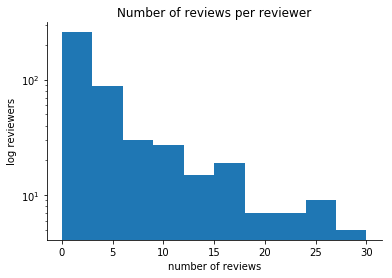

In [54]:
# enter your code here
# plots graph, changes color, changes bins to $1000
temp = reviews.groupby('critic').count()
temp = temp['quote']



plt.hist(temp, log = True, range = (0,30))
#axes = plt.gca()
#axes.set_ylim([0,1200])

ax = plt.axes()
plt.title('Number of reviews per reviewer')
plt.xlabel('number of reviews')
plt.ylabel('log reviewers')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [55]:
# enter your code here
temp = reviews.groupby('critic').count()
df = temp.nlargest(30, 'quote')
names = df.index
storage = {}
for name in names:
    df = reviews.loc[reviews['critic'] == name]
    pub = df.publication.unique()
    datef = df.review_date.min()
    datel = df.review_date.max()
    a_list = [pub, datef, datel]
    storage[name] = a_list
    
df = pd.DataFrame.from_dict(storage)
df

,Bosley Crowther,Dave Kehr,Derek Adams,Desson Thomson,Edward Guthmann,Emanuel Levy,Geoff Andrew,Hal Hinson,James Berardinelli,Janet Maslin,...,Richard Corliss,Richard Schickel,Rick Groen,Rita Kempley,Roger Ebert,Stephen Holden,Susan Stark,Todd McCarthy,Variety Staff,Vincent Canby
0,[New York Times],"[Chicago Reader, New York Daily News, Chicago ...",[Time Out],[Washington Post],[San Francisco Chronicle],[Variety],[Time Out],[Washington Post],[ReelViews],[New York Times],...,[TIME Magazine],"[TIME Magazine, The Atlantic]",[Globe and Mail],[Washington Post],"[Chicago Sun-Times, At the Movies]",[New York Times],[Detroit News],[Variety],[Variety],[New York Times]
1,2000-01-01 00:00:00,2000-01-01 00:00:00,2006-01-26 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2005-08-11 00:00:00,2000-01-01 00:00:00,1800-01-01 00:00:00,2000-01-01 00:00:00,...,2003-12-16 00:00:00,2000-01-01 00:00:00,2002-03-19 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2000-01-01 00:00:00,2001-02-13 00:00:00,2000-01-01 00:00:00
2,2008-05-06 00:00:00,2013-11-20 00:00:00,2009-10-04 00:00:00,2012-10-08 00:00:00,2003-04-04 00:00:00,2010-08-06 00:00:00,2012-04-05 00:00:00,2013-06-26 00:00:00,2012-02-07 00:00:00,2010-09-07 00:00:00,...,2013-11-06 00:00:00,2013-08-05 00:00:00,2009-08-14 00:00:00,2013-11-02 00:00:00,2013-06-11 00:00:00,2009-02-06 00:00:00,2002-10-25 00:00:00,2012-10-09 00:00:00,2012-08-15 00:00:00,2013-07-29 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

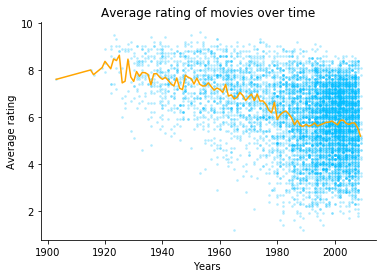

In [56]:
# enter your code here
# getting rid of unknows and 0 values
movies = movies[movies['rtAllCriticsRating'] != '\\N']
movies = movies[movies['rtAllCriticsRating'] != '0']


# changing movie data into float values
movies_float = movies.copy()
params = ['rtAllCriticsRating', 'rtAllCriticsNumReviews', 'rtAllCriticsNumFresh',
'rtAllCriticsNumRotten','rtAllCriticsScore','rtTopCriticsRating','rtTopCriticsNumReviews',
'rtTopCriticsNumFresh','rtTopCriticsNumRotten','rtTopCriticsScore','rtAudienceRating',
'rtAudienceNumRatings','rtAudienceScore']
def makeFloats(df, params):
    for param in params:
        df[param] = pd.to_numeric(df['rtAllCriticsRating'], errors='coerce')

# changing movies values into floats 
makeFloats(movies_float, params)  

by_year = movies_float.groupby('year')['rtAllCriticsRating'].mean()

# scatter plots
ax = plt.axes()
ax.scatter(movies.year, movies.rtAllCriticsRating.apply(float), s = 3, alpha = .2, color = 'deepskyblue')

# for drawing the line 
ax.plot(by_year, color = 'orange')

plt.title('Average rating of movies over time')
plt.xlabel('Years ')
plt.ylabel('Average rating')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)







There are a lot more reviews in the last 30 years. The average review is also slightly lower. Perhaps more movies have been produced, and movie expectations have increased. 

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [57]:
# X, Y = make_xy(reviews)
# print(X.shape, Y.shape)
import io
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)

# cleaning quotes before extracting features

result = []
lines = np.array(reviews.quote)
print(lines.shape)
for row in lines:
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in row.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n '.join(chunk for chunk in chunks if chunk)
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace("\n", ' ').replace('\\b', ' ')
    # gets rid of escape characters
    text = bytes(text, "utf-8").decode("unicode_escape")
    # gets rid of links 
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    # getting rid of punctuation 
    text = ''.join(ch for ch in text if ch not in exclude)
    # make text lower case
    text = text.lower()

    # remove stop words before csv was written
    text = word_tokenize(text)
    resultwords  = [word for word in text if word not in stop_words]
    text = ' '.join(resultwords)
    result.append(text)

# adding clean words to reviews df
clean = np.array(result)
clean.size
reviews['clean'] = clean

# getting rid of null, empty rows in "clean" column
reviews = reviews[~reviews.clean.isnull()]
reviews = reviews[reviews.clean.str.len() > 0]
reviews = reviews.dropna()

(13419,)


In [58]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print ("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print ("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [76]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)

"""
from string import digits
import string

# removing punction and numbers from quotes


# so runs on my computer
#n_reviews = reviews[0:1000]
vec = CountVectorizer(min_df=0)
def make_xy(reviews, vec=None):
    if vec == None:
        vec = CountVectorizer(min_df=0, stop_words='english')
    X = vec.fit(reviews.clean)
    X = vec.transform(reviews.clean)
    X = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
    X = X.fillna(0)
    X = np.array(X)
    Y = reviews.fresh.replace('fresh',1).replace('rotten',0) 
    Y = np.array(Y)
    return X, Y


In [60]:
X,Y = make_xy(reviews)


### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [77]:
# enter your code here
# splitting test and train data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12345, test_size=0.33)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [78]:
# call the fitted model fitted_model, for future reference:
fitted_model = MultinomialNB()
fitted_model.fit(X_train, y_train)
print("accuracy score of train data: ", fitted_model.score(X_train, y_train))
preds = fitted_model.predict(X_test)

# preds score (percentage of the time that the predictions equal the data)
accuracy = (preds == y_test).sum()/len(y_test)
print("accuracy of predictions: ", accuracy)

accuracy score of train data:  0.938622227438
accuracy of predictions:  0.766738146295


Though the training data had a great score, the model only predicted correctly about 60% of the time. Perhaps too many features? 

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [32]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [79]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood_score(y, y_pred, estimator):
    prob = estimator.predict_log_proba(y)
    rotten = y_pred == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood_score(X_test, y_test, fitted_model)

-2443.7688806015612

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

#for alpha in alphas:
score = make_scorer(log_likelihood_score)
# param_grid for gridsearchCV
param_grid ={'alpha': alphas }

for min_df in min_dfs:
    for alpha in alphas: 
        # creating new CountVectorizer with assigned min_dif
        vectorizer = CountVectorizer(min_df = min_df)  
        X, Y = make_xy(reviews, vectorizer)
        # splitting train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12345, test_size=0.33)
        # using grid search for cross validation. 
        #grid = GridSearchCV(MultinomialNB(), param_grid = param_grid, n_jobs=6)
        score = cross_val_score(MultinomialNB(alpha = alpha), X_train, y_train, cv=KFold(n_splits = 10, shuffle=True), scoring = log_likelihood_score).mean()
        #grid.fit(X_train, y_train)
        #best_score = grid.best_score_ 
        #llh = log_likelihood_score(grid, X_train, y_train)
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df
            


/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by 

In [83]:
print("Max_loglike:", max_loglike, "best alpha: ", best_alpha, "best min_df:", best_min_df )


Max_loglike:  -453.942512987 best alpha:  5 best min_df: 0.001


In [81]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# using grid search
# creating parameters for pipeline for cross validation: 
pipeline = Pipeline([
     ('vect', CountVectorizer()),
      ('model', MultinomialNB()),
 ])

# parameters to tweek in pipeline
param_grid ={'vect__min_df': min_dfs,
             'model__alpha': [0, .1, 1, 5, 10, 50]}


score = make_scorer(log_likelihood_score, needs_proba = True, greater_is_better = True, estimator = pipeline)

# re-splitting data without converting into CountVector to put into pipeline
X_train, X_test, y_train, y_test = train_test_split(reviews.quote, reviews.fresh.replace('fresh', 1).replace('rotten', 0), random_state = 12345, test_size=0.33)

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block
    
    #finding best alpha and min_df

    grid = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1, scoring = score)
    grid.fit(X_train, y_train)
    log_like = log_likelihood_score(grid, X_train, y_train)
    print(log_like)
    print('accuracy: ', grid.score(X_train, y_train))
    print("pipeline:", [name for name, _ in pipeline.steps])
    best_parameters = grid.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\tbest parameters for ", param_name)
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: i

JoblibNotFittedError: JoblibNotFittedError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda/envs/python3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda/envs/python3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10480b390, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda/envs/python3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda/en.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10480b390, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda/envs/python3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda/en.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 1, 23, 12, 49, 810947, tzinfo=datetime.timezone.utc), 'msg_id': '692C8A13E54A45CDBFE712DC38CB233F', 'msg_type': 'execute_request', 'session': '2AC10DCCF9664229872DC4922A1CBB3B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '692C8A13E54A45CDBFE712DC38CB233F', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2AC10DCCF9664229872DC4922A1CBB3B']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 1, 23, 12, 49, 810947, tzinfo=datetime.timezone.utc), 'msg_id': '692C8A13E54A45CDBFE712DC38CB233F', 'msg_type': 'execute_request', 'session': '2AC10DCCF9664229872DC4922A1CBB3B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '692C8A13E54A45CDBFE712DC38CB233F', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2AC10DCCF9664229872DC4922A1CBB3B'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 1, 23, 12, 49, 810947, tzinfo=datetime.timezone.utc), 'msg_id': '692C8A13E54A45CDBFE712DC38CB233F', 'msg_type': 'execute_request', 'session': '2AC10DCCF9664229872DC4922A1CBB3B', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '692C8A13E54A45CDBFE712DC38CB233F', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.metrics import make_scorer\nfrom skl...%r" % (param_name, best_parameters[param_name]))\n', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.If object>], cell_name='<ipython-input-81-c307667d29d3>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1133d7630, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x118a8d5d0, file "<ipython-input-81-c307667d29d3>", line 23>
        result = <ExecutionResult object at 1133d7630, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x118a8d5d0, file "<ipython-input-81-c307667d29d3>", line 23>, result=<ExecutionResult object at 1133d7630, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x118a8d5d0, file "<ipython-input-81-c307667d29d3>", line 23>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "reviews = pd.read_csv('reviews.csv')\nmovies = pd...ws.quote = reviews.quote.str.replace('[0-9]', '')", '# enter your code below\n\nprint ("Number of revie...ve reviews: ", len(reviews.publication.unique()))', "# enter your code here\n# plots graph, changes co...isible(False)\nax.spines['top'].set_visible(False)", "# enter your code here\ntemp = reviews.groupby('c...list\n    \ndf = pd.DataFrame.from_dict(storage)\ndf", "# enter your code here\n# getting rid of unknows ...isible(False)\nax.spines['top'].set_visible(False)", '# X, Y = make_xy(reviews)\n# print(X.shape, Y.sha...s.clean.str.len() > 0]\nreviews = reviews.dropna()', "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "reviews = pd.read_csv('reviews.csv')\nmovies = pd...ws.quote = reviews.quote.str.replace('[0-9]', '')", '# enter your code below\n\nprint ("Number of revie...ve reviews: ", len(reviews.publication.unique()))', "# enter your code here\n# plots graph, changes co...isible(False)\nax.spines['top'].set_visible(False)", "# enter your code here\ntemp = reviews.groupby('c...list\n    \ndf = pd.DataFrame.from_dict(storage)\ndf", "# enter your code here\n# getting rid of unknows ...isible(False)\nax.spines['top'].set_visible(False)", '# X, Y = make_xy(reviews)\n# print(X.shape, Y.sha...s.clean.str.len() > 0]\nreviews = reviews.dropna()', 'from sklearn.feature_extraction.text import Coun... feature:")\nprint(vectorizer.get_feature_names())', '"""\nFunction\n--------\nmake_xy\n\nBuild a bag-of-wo...(\'rotten\',0) \n    Y = np.array(Y)\n    return X, Y', 'X,Y = make_xy(reviews)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {6:        Bosley Crowther                          ...:00  2013-07-29 00:00:00  

[3 rows x 30 columns], 14:        Bosley Crowther                          ...:00  2013-07-29 00:00:00  

[3 rows x 30 columns], 23: -2443.7688806015612, 33: -2443.7688806015612, 55:        Bosley Crowther                          ...:00  2013-07-29 00:00:00  

[3 rows x 30 columns], 63: -2443.7688806015612, 79: -2443.7688806015612}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "reviews = pd.read_csv('reviews.csv')\nmovies = pd...ws.quote = reviews.quote.str.replace('[0-9]', '')", '# enter your code below\n\nprint ("Number of revie...ve reviews: ", len(reviews.publication.unique()))', "# enter your code here\n# plots graph, changes co...isible(False)\nax.spines['top'].set_visible(False)", "# enter your code here\ntemp = reviews.groupby('c...list\n    \ndf = pd.DataFrame.from_dict(storage)\ndf", "# enter your code here\n# getting rid of unknows ...isible(False)\nax.spines['top'].set_visible(False)", '# X, Y = make_xy(reviews)\n# print(X.shape, Y.sha...s.clean.str.len() > 0]\nreviews = reviews.dropna()', "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "get_ipython().magic('matplotlib inline')\nimport ...ndardScaler\nfrom sklearn.decomposition import PCA", "reviews = pd.read_csv('reviews.csv')\nmovies = pd...ws.quote = reviews.quote.str.replace('[0-9]', '')", '# enter your code below\n\nprint ("Number of revie...ve reviews: ", len(reviews.publication.unique()))', "# enter your code here\n# plots graph, changes co...isible(False)\nax.spines['top'].set_visible(False)", "# enter your code here\ntemp = reviews.groupby('c...list\n    \ndf = pd.DataFrame.from_dict(storage)\ndf", "# enter your code here\n# getting rid of unknows ...isible(False)\nax.spines['top'].set_visible(False)", '# X, Y = make_xy(reviews)\n# print(X.shape, Y.sha...s.clean.str.len() > 0]\nreviews = reviews.dropna()', 'from sklearn.feature_extraction.text import Coun... feature:")\nprint(vectorizer.get_feature_names())', '"""\nFunction\n--------\nmake_xy\n\nBuild a bag-of-wo...(\'rotten\',0) \n    Y = np.array(Y)\n    return X, Y', 'X,Y = make_xy(reviews)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {6:        Bosley Crowther                          ...:00  2013-07-29 00:00:00  

[3 rows x 30 columns], 14:        Bosley Crowther                          ...:00  2013-07-29 00:00:00  

[3 rows x 30 columns], 23: -2443.7688806015612, 33: -2443.7688806015612, 55:        Bosley Crowther                          ...:00  2013-07-29 00:00:00  

[3 rows x 30 columns], 63: -2443.7688806015612, 79: -2443.7688806015612}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,..., ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/iguest/Desktop/hw5/hw-5/<ipython-input-81-c307667d29d3> in <module>()
     25     # block
     26     
     27     #finding best alpha and min_df
     28 
     29     grid = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1, scoring = score)
---> 30     grid.fit(X_train, y_train)
     31     log_like = log_likelihood_score(grid, X_train, y_train)
     32     print(log_like)
     33     print('accuracy: ', grid.score(X_train, y_train))
     34     print("pipeline:", [name for name, _ in pipeline.steps])

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...rior=None, fit_prior=True))])),
       verbose=1), X=591      Whatever Murphy was thinking during the... free...
Name: quote, Length: 8521, dtype: object, y=591      1
12286    1
12123    1
121      0
8779...811     1
Name: fresh, Length: 8521, dtype: int64, groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...ior=None, fit_prior=True))])),
       verbose=1)>
        X = 591      Whatever Murphy was thinking during the... free...
Name: quote, Length: 8521, dtype: object
        y = 591      1
12286    1
12123    1
121      0
8779...811     1
Name: fresh, Length: 8521, dtype: int64
        groups = None
        self.param_grid = {'model__alpha': [0, 0.1, 1, 5, 10, 50], 'vect__min_df': [1e-05, 0.0001, 0.001, 0.01, 0.1]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...rior=None, fit_prior=True))])),
       verbose=1), X=591      Whatever Murphy was thinking during the... free...
Name: quote, Length: 8521, dtype: object, y=591      1
12286    1
12123    1
121      0
8779...811     1
Name: fresh, Length: 8521, dtype: int64, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
NotFittedError                                     Fri Jun  1 16:12:50 2018
PID: 11355                  Python 3.6.1: /anaconda/envs/python3/bin/python
...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))]), 591      Whatever Murphy was thinking during the... free...
Name: quote, Length: 8521, dtype: object, 591      1
12286    1
12123    1
121      0
8779...811     1
Name: fresh, Length: 8521, dtype: int64, make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))])), array([2804, 2805, 2808, ..., 8518, 8519, 8520]), array([   0,    1,    2, ..., 2856, 2857, 2858]), 1, {'model__alpha': 0, 'vect__min_df': 1e-05}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))]), 591      Whatever Murphy was thinking during the... free...
Name: quote, Length: 8521, dtype: object, 591      1
12286    1
12123    1
121      0
8779...811     1
Name: fresh, Length: 8521, dtype: int64, make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))])), array([2804, 2805, 2808, ..., 8518, 8519, 8520]), array([   0,    1,    2, ..., 2856, 2857, 2858]), 1, {'model__alpha': 0, 'vect__min_df': 1e-05})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))]), X=591      Whatever Murphy was thinking during the... free...
Name: quote, Length: 8521, dtype: object, y=591      1
12286    1
12123    1
121      0
8779...811     1
Name: fresh, Length: 8521, dtype: int64, scorer=make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))])), train=array([2804, 2805, 2808, ..., 8518, 8519, 8520]), test=array([   0,    1,    2, ..., 2856, 2857, 2858]), verbose=1, parameters={'model__alpha': 0, 'vect__min_df': 1e-05}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))])
        X_test = 591      Whatever Murphy was thinking during the...y det...
Name: quote, Length: 2841, dtype: object
        y_test = 591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64
        scorer = make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))]))
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))]), X_test=591      Whatever Murphy was thinking during the...y det...
Name: quote, Length: 2841, dtype: object, y_test=591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64, scorer=make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))])))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))]))
        estimator = Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))])
        X_test = 591      Whatever Murphy was thinking during the...y det...
Name: quote, Length: 2841, dtype: object
        y_test = 591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(log_likelihood_score, needs_proba=Tr...(alpha=1.0, class_prior=None, fit_prior=True))])), clf=Pipeline(steps=[('vect', CountVectorizer(analyze...lNB(alpha=0, class_prior=None, fit_prior=True))]), X=591      Whatever Murphy was thinking during the...y det...
Name: quote, Length: 2841, dtype: object, y=591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64, sample_weight=None)
    129         if sample_weight is not None:
    130             return self._sign * self._score_func(y, y_pred,
    131                                                  sample_weight=sample_weight,
    132                                                  **self._kwargs)
    133         else:
--> 134             return self._sign * self._score_func(y, y_pred, **self._kwargs)
        self._sign = 1
        self._score_func = <function log_likelihood_score>
        y = 591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64
        y_pred = array([[        nan,         nan],
       [ 0.  ... 1.        ],
       [ 0.06801484,  0.93198516]])
        self._kwargs = {'estimator': Pipeline(steps=[('vect', CountVectorizer(analyze...B(alpha=1.0, class_prior=None, fit_prior=True))])}
    135 
    136     def _factory_args(self):
    137         return ", needs_proba=True"
    138 

...........................................................................
/Users/iguest/Desktop/hw5/hw-5/<ipython-input-79-7854d5641cc7> in log_likelihood_score(y=591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64, y_pred=array([[        nan,         nan],
       [ 0.  ... 1.        ],
       [ 0.06801484,  0.93198516]]), estimator=Pipeline(steps=[('vect', CountVectorizer(analyze...B(alpha=1.0, class_prior=None, fit_prior=True))]))
     19 y : (nexample) integer array
     20     Whether each review is Fresh
     21 """
     22 
     23 def log_likelihood_score(y, y_pred, estimator):
---> 24     prob = estimator.predict_log_proba(y)
     25     rotten = y_pred == 0
     26     fresh = ~rotten
     27     return prob[rotten, 0].sum() + prob[fresh, 1].sum()
     28 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in <lambda>(*args=(591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64,), **kwargs={})
     49                     break
     50             else:
     51                 attrgetter(self.delegate_names[-1])(obj)
     52 
     53         # lambda, but not partial, allows help() to work with update_wrapper
---> 54         out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
        args = (591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64,)
        kwargs = {}
     55         # update the docstring of the returned function
     56         update_wrapper(out, self.fn)
     57         return out
     58 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/pipeline.py in predict_log_proba(self=Pipeline(steps=[('vect', CountVectorizer(analyze...B(alpha=1.0, class_prior=None, fit_prior=True))]), X=591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64)
    411         y_score : array-like, shape = [n_samples, n_classes]
    412         """
    413         Xt = X
    414         for name, transform in self.steps[:-1]:
    415             if transform is not None:
--> 416                 Xt = transform.transform(Xt)
        Xt = 591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64
        transform.transform = <bound method CountVectorizer.transform of Count...w+\\b',
        tokenizer=None, vocabulary=None)>
    417         return self.steps[-1][-1].predict_log_proba(Xt)
    418 
    419     @property
    420     def transform(self):

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in transform(self=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None), raw_documents=591      1
12286    1
12123    1
121      0
8779...198     1
Name: fresh, Length: 2841, dtype: int64)
    885                 "string object received.")
    886 
    887         if not hasattr(self, 'vocabulary_'):
    888             self._validate_vocabulary()
    889 
--> 890         self._check_vocabulary()
        self._check_vocabulary = <bound method VectorizerMixin._check_vocabulary ...w+\\b',
        tokenizer=None, vocabulary=None)>
    891 
    892         # use the same matrix-building strategy as fit_transform
    893         _, X = self._count_vocab(raw_documents, fixed_vocab=True)
    894         if self.binary:

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in _check_vocabulary(self=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None))
    273             self.fixed_vocabulary_ = False
    274 
    275     def _check_vocabulary(self):
    276         """Check if vocabulary is empty or missing (not fit-ed)"""
    277         msg = "%(name)s - Vocabulary wasn't fitted."
--> 278         check_is_fitted(self, 'vocabulary_', msg=msg),
        self = CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None)
        msg = "%(name)s - Vocabulary wasn't fitted."
    279 
    280         if len(self.vocabulary_) == 0:
    281             raise ValueError("Vocabulary is empty")
    282 

...........................................................................
/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py in check_is_fitted(estimator=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None), attributes=['vocabulary_'], msg="%(name)s - Vocabulary wasn't fitted.", all_or_any=<built-in function all>)
    685     if not isinstance(attributes, (list, tuple)):
    686         attributes = [attributes]
    687 
    688     if not all_or_any([hasattr(estimator, attr) for attr in attributes]):
    689         # FIXME NotFittedError_ --> NotFittedError in 0.19
--> 690         raise _NotFittedError(msg % {'name': type(estimator).__name__})
        msg = "%(name)s - Vocabulary wasn't fitted."
        estimator.__name__ = undefined
    691 
    692 
    693 def check_non_negative(X, whom):
    694     """

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.
___________________________________________________________________________

### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [85]:
vec = CountVectorizer(min_df=best_min_df)
X, Y = make_xy(reviews, vec)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12345, test_size=0.33)

fitted_model = MultinomialNB(alpha=best_alpha)
fitted_model.fit(X_train, y_train)
print("accuracy score of train data: ", fitted_model.score(X_train, y_train))
preds = fitted_model.predict(X_test)

# preds score (percentage of the time that the predictions equal the data)
accuracy = (preds == y_test).sum()/len(y_test)
print("accuracy of predictions: ", accuracy)

accuracy score of train data:  0.797206900599
accuracy of predictions:  0.735763640696


In [135]:
#Enter your code here
print(X_test.shape)
X_train.shape
fitted_model.classes_

(4197, 22268)


array([0, 1])

This new model had slightly better predictions, but the same train data accuracy. May perhaps slightly better with handeling overfitting

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [103]:
#Enter your code here

*enter your observations here*

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [86]:
# geting feature names
words = vec.get_feature_names()

# finding predicted propability using trained model and words
i = np.identity(len(words))
df = pd.DataFrame(i, columns = words)
prop = fitted_model.predict_proba(df)  


In [87]:
# puting predicted propabilites of each word in a dataframe for easier wrangeling 
props = pd.DataFrame(prop, columns = ['prop_rot', 'prop_fresh'])
props['word'] = words
print("Top 10 words that best predict fresh reviews\n",props.nlargest(10, 'prop_fresh'))
print()
print("Top 10 words that best predict rotten reviews\n",props.nlargest(10, 'prop_rot'))


Top 10 words that best predict fresh reviews
       prop_rot  prop_fresh         word
902   0.102726    0.897274  intelligent
1809  0.102726    0.897274     touching
419   0.128710    0.871290      delight
1074  0.132433    0.867567  masterpiece
1701  0.132433    0.867567       superb
1382  0.144000    0.856000         rare
154   0.146383    0.853617         best
316   0.146561    0.853439      complex
750   0.146561    0.853439        gives
139   0.147346    0.852654    beautiful

Top 10 words that best predict rotten reviews
       prop_rot  prop_fresh             word
1861  0.810396    0.189604    unfortunately
968   0.808175    0.191825             lame
1306  0.785571    0.214429        pointless
608   0.770551    0.229449            fails
1862  0.767290    0.232710          unfunny
168   0.758465    0.241535            bland
1863  0.756929    0.243071       uninspired
1339  0.753267    0.246733          problem
457   0.753267    0.246733   disappointment
456   0.745602    0.254398

This is a really fun exercise, and good sanity check on my model! All of these words make sence to be in either a fresh or rotten review. I also included the predicted propability for a further sanity check.  

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [233]:
#Your code here

# looks at all the words and eaching qote, and then gives a general rating based on the classified propability 
# of that word being in a fresh or rotten review
new_lines = np.array(reviews.clean)
ratings = []
for line in new_lines: 
    r = 0
    f = 0
    for w in line.split():

        value = props.loc[props.word == w]
        if not value.word.empty:
            v1 = value['prop_rot']
            v2 = value['prop_fresh']
            if(v1.item() > v2.item()):
                r +=1
            else:
                f += 1
    if(r > f):
        rate = 0
    else:
        rate = 1
        
    ratings.append(rate)


In [256]:
# appends preds to reviews df
reviews['pred'] = ratings
reviews.fresh = reviews.fresh.replace('fresh', 1).replace('rotten', 0)

# looking where preds and fresh ratings do not match 
df = reviews[reviews.pred != reviews.fresh]

# printing incorrect ratings 
quotes = np.array(df.quote)
print("INCORRECTLY CLASSIFIED RATINGS")
print()
for i in range(0,5):
    print(i, ")", quotes[i])
    print()

INCORRECTLY CLASSIFIED RATINGS

0 ) A gloomy specialeffects extravaganza filled with grotesque images generating fear and despair

1 ) The movie is too pat and practiced to really be convincing and the progress of Ariels relationships with the two grumps seems dictated mostly by the needs of the screenplay

2 ) Never escapes the queasy aura of Melrose Place just another story about beautiful people with small problems

3 ) The malebashing taken to an extreme in Waiting to Exhale is starting to seem a little like crack for the female psyche exhilarating in the short term but ultimately crippling and dangerous

4 ) With one possible exception none of its women is at all likable



These miss  predictions contain words that are highly rated fresh but in a rotten review or highly rated rotten by in a fresh review. This is because Niave Bayes calassifiers look at each word independtly and removes context. Context is a huge part of the english language; a way to compat this may be to bag multiple words, rather than singular words. The example review above would get fresh rating from the classifier because it contains a large number of fresh words. However, this would be wrong.  

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [88]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

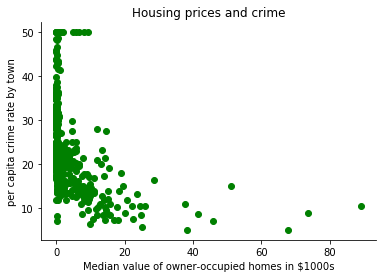

In [91]:
# Enter your code here
%matplotlib inline  
import matplotlib.pyplot as plt  

# puting data in dataframe
data_pd = pd.DataFrame(columns=bdata.feature_names, data=bdata.data)
data_pd['outcome'] = bdata.target 

# plots graph, changes color, changes bins to $1000
plt.scatter(data_pd.CRIM,bdata.target, color='green')

# Adds appropriate labels to the x and y axes 
plt.title('Housing prices and crime')
plt.xlabel('Median value of owner-occupied homes in $1000s')
plt.ylabel('per capita crime rate by town')

#Remove the axes on the top and right side of the plot window
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [96]:
# for computing rmse
def compute_rmse(predictions, yvalues):
   
    total_sum = 0
    for i, value in enumerate(yvalues):
        dif = (predictions[i] - yvalues[i]) ** 2
        total_sum = total_sum + dif
    f = total_sum / len(yvalues)
    rmse = np.sqrt(f)
    return rmse


In [153]:
# splitting train/test data
features = data_pd.RM
print(features.shape)
target = data_pd.outcome
print(target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 12345, test_size=0.34)

#reshaping for linear regresssion
X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(506,)
(506,)
(333, 1) (333, 1)
(173, 1) (173, 1)


In [158]:
from sklearn.linear_model import LinearRegression

# regression model
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
pred = regr.predict(X_test)

# checking RMSE
rmse = compute_rmse(pred,y_test)
print('RMSE:', rmse[0])

RMSE: 6.41925719387


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

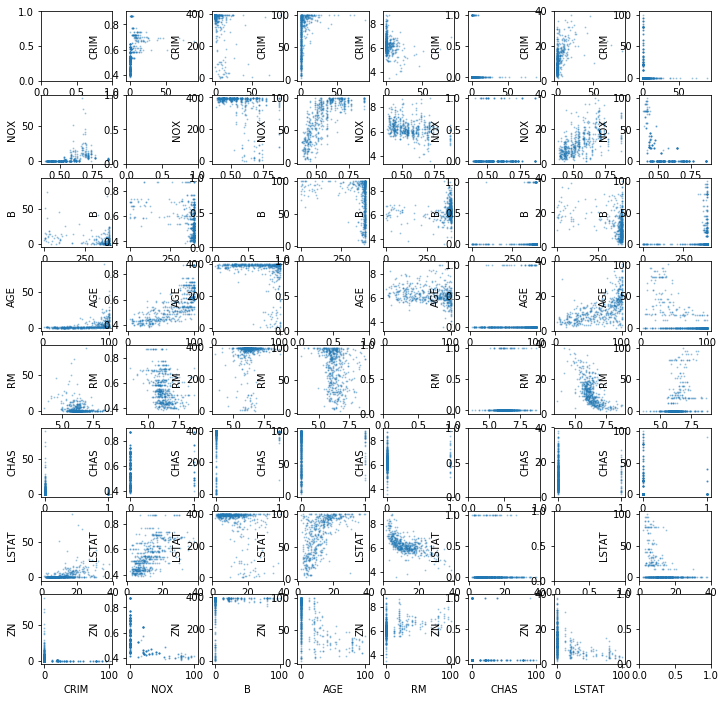

In [188]:
plt.figure(figsize=(12,12))
f = ['CRIM', 'NOX', 'B', 'AGE', 'RM', 'CHAS', 'LSTAT', 'ZN']
for i in range(8):
    for j in range(8):
       
        fig = plt.subplot(8, 8, i * 8 + j + 1)
        if i != j:
            plt.scatter(data_pd[f[i]],data_pd[f[j]], alpha = .3, s = 1, label = f[i])
            plt.ylabel(f[i])
            plt.xlabel(f[j]) 
        
        # insert your code here

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [34]:
# Enter your code here

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [34]:
# Enter your code here

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

*Enter your observations here*